In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
def get_lower(x: str) -> str:
    return x.replace(' ', '_').lower()

def one_hot_encoding(df, cat_features=None, drop_original=True):
    df_copy = df.copy()
    if cat_features is None:
        cat_features = df.columns
    for feature in cat_features:
        df_copy = pd.concat([df_copy, 
                             pd.get_dummies(df[feature], 
                                            prefix=feature, 
                                            dummy_na=True)
                            ],
                            axis=1)
    if drop_original:
        df_copy.drop(cat_features, axis=1, inplace=True)
    return df_copy

def agg_features(df, df_out, by: str):
    df_copy = df.copy()
    df_out_copy = df_out.copy()
    cols = df_copy.drop(by, axis=1).columns
    for feature in cols:
        feature_groupby = df_copy.groupby(by, as_index=False)
        feature_counts = feature_groupby[feature].mean()
        feature_counts = feature_counts.rename(columns={
            feature: feature + f'_mean'
        })
        df_out_copy = df_out_copy.merge(feature_counts, how="left", on=by)
    return df_out_copy

def get_input(data_path: str,
              base_path: str= './data/',
              col_lower=True) -> pd.DataFrame:
    data = pd.read_csv(f'{base_path}/{data_path}')
    if col_lower:
        data.columns = [col.lower() for col in data.columns]
    print(f'{data_path}: {data.shape[0]} rows, {data.shape[1]} cols')
    return data


def clip_outliers(X, lower=0.005, upper=0.995):
    new_X = X.copy()
    new_X = new_X.apply(lambda x: x.clip(*x.quantile([lower, upper])), axis=1)

    return new_X

def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

def get_isna_features(X):
    X_copy = X.copy()
    for feature in X.columns:
        new_f = np.zeros(X.shape[0])
        new_f = X[feature].isna()
        X_copy[f'isna_{feature}'] = new_f.astype(int)
    return X_copy

In [3]:
train = get_input('train.csv')
test = get_input('test.csv')

train.csv: 110093 rows, 3 cols
test.csv: 165141 rows, 2 cols


In [4]:
target_name = 'target'
target = train[target_name]

In [5]:
app_history = get_input('applications_history.csv')
app_history.head(3)

applications_history.csv: 1670214 rows, 26 cols


,prev_application_number,application_number,name_contract_type,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,name_contract_status,days_decision,...,name_product_type,sellerplace_area,cnt_payment,name_yield_group,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0


In [6]:
train = train.merge(app_history, how="left", on='application_number')
test = test.merge(app_history, how="left", on='application_number')

In [7]:
numerical_features = app_history.select_dtypes(exclude=["object"]).columns.tolist()
categorical_features = app_history.select_dtypes(include=["object"]).columns.tolist()

In [8]:
### categorical

In [9]:
for feature in app_history[categorical_features].columns.tolist():
    print()
    print(app_history[feature].value_counts())


Cash           747553
Credit Card    193164
Name: name_contract_type, dtype: int64

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: name_contract_status, dtype: int64

Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: name_payment_type, dtype: int64

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: code_reject_reason, dtype: int64

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: name_type_suite, dtype: int64

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: name_client_typ

In [10]:
app_history_ohe = one_hot_encoding(app_history, 
                                   cat_features=categorical_features, 
                                   drop_original=True)

In [11]:
train = agg_features(app_history_ohe, train, by='application_number')

In [12]:
numerical_features = train.select_dtypes(exclude=["object"]).columns.tolist()
categorical_features = train.select_dtypes(include=["object"]).columns.tolist()

In [13]:
koef = round(target.value_counts()[0] / target.value_counts()[1])
koef

11

In [14]:
# categorical_features.remove('name_contract_type')

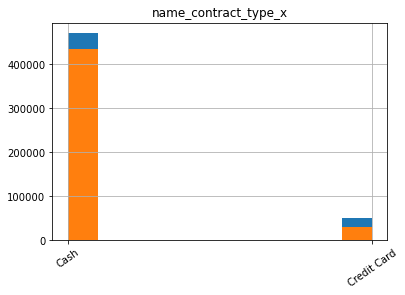

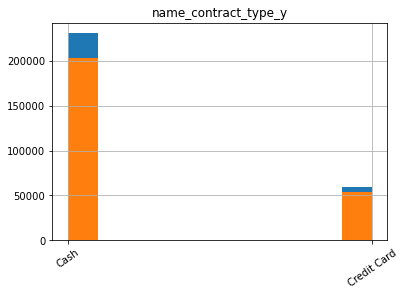

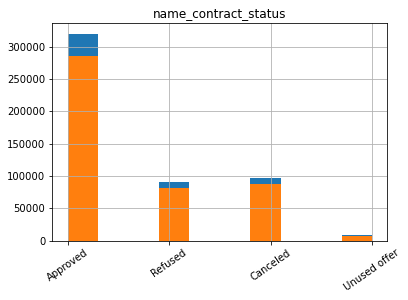

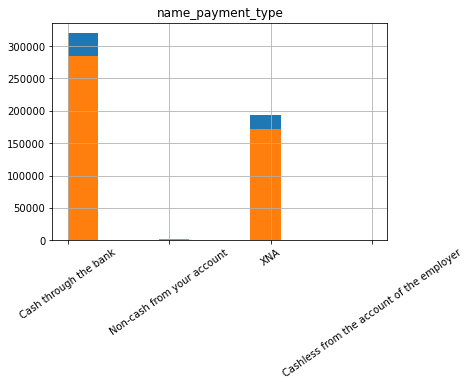

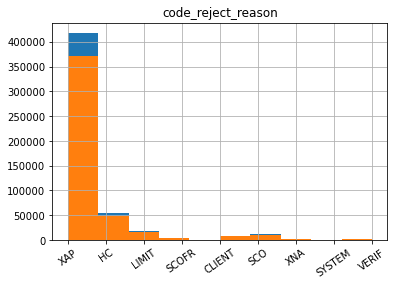

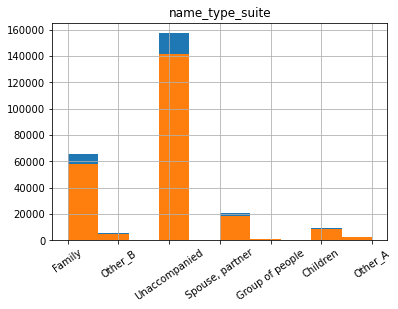

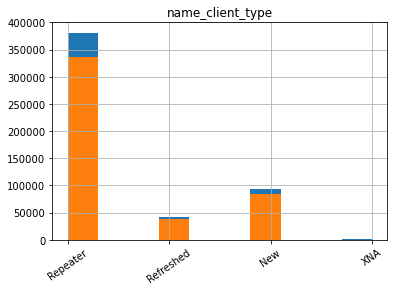

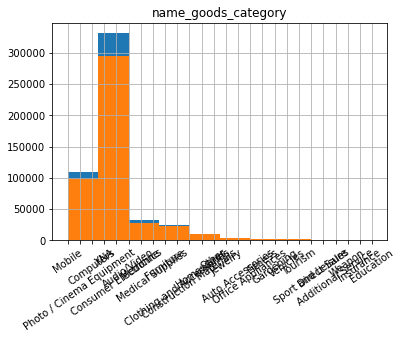

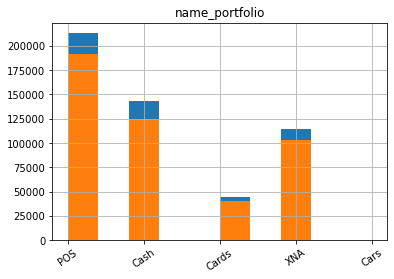

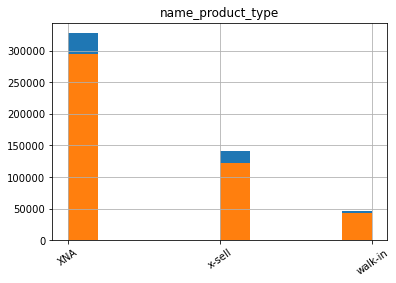

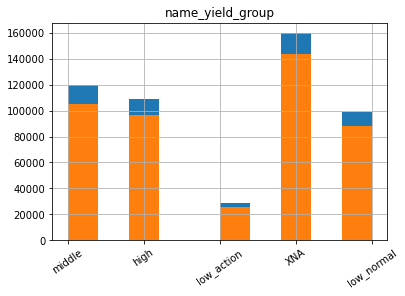

In [15]:
for feature in categorical_features:
    plt.title(feature)
    train[feature].hist()
    data_target = train.loc[train[target_name] == 1, feature]
    data_target = pd.concat([data_target for _ in range(koef)], axis=0)
    data_target.hist()
    plt.xticks(rotation=35)
    plt.show()

Не видно отличий

In [16]:
### descrete

In [19]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25
]

In [20]:
train[discrete_feature].head()

,target,nflag_insured_on_approval,name_contract_status_nan_mean,name_payment_type_nan_mean,code_reject_reason_nan_mean,name_client_type_nan_mean,name_goods_category_Additional Service_mean,name_goods_category_Animals_mean,name_goods_category_Direct Sales_mean,name_goods_category_Education_mean,name_goods_category_Fitness_mean,name_goods_category_House Construction_mean,name_goods_category_Insurance_mean,name_goods_category_Weapon_mean,name_goods_category_nan_mean,name_portfolio_nan_mean,name_product_type_nan_mean,name_yield_group_nan_mean
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
len(discrete_feature)

18

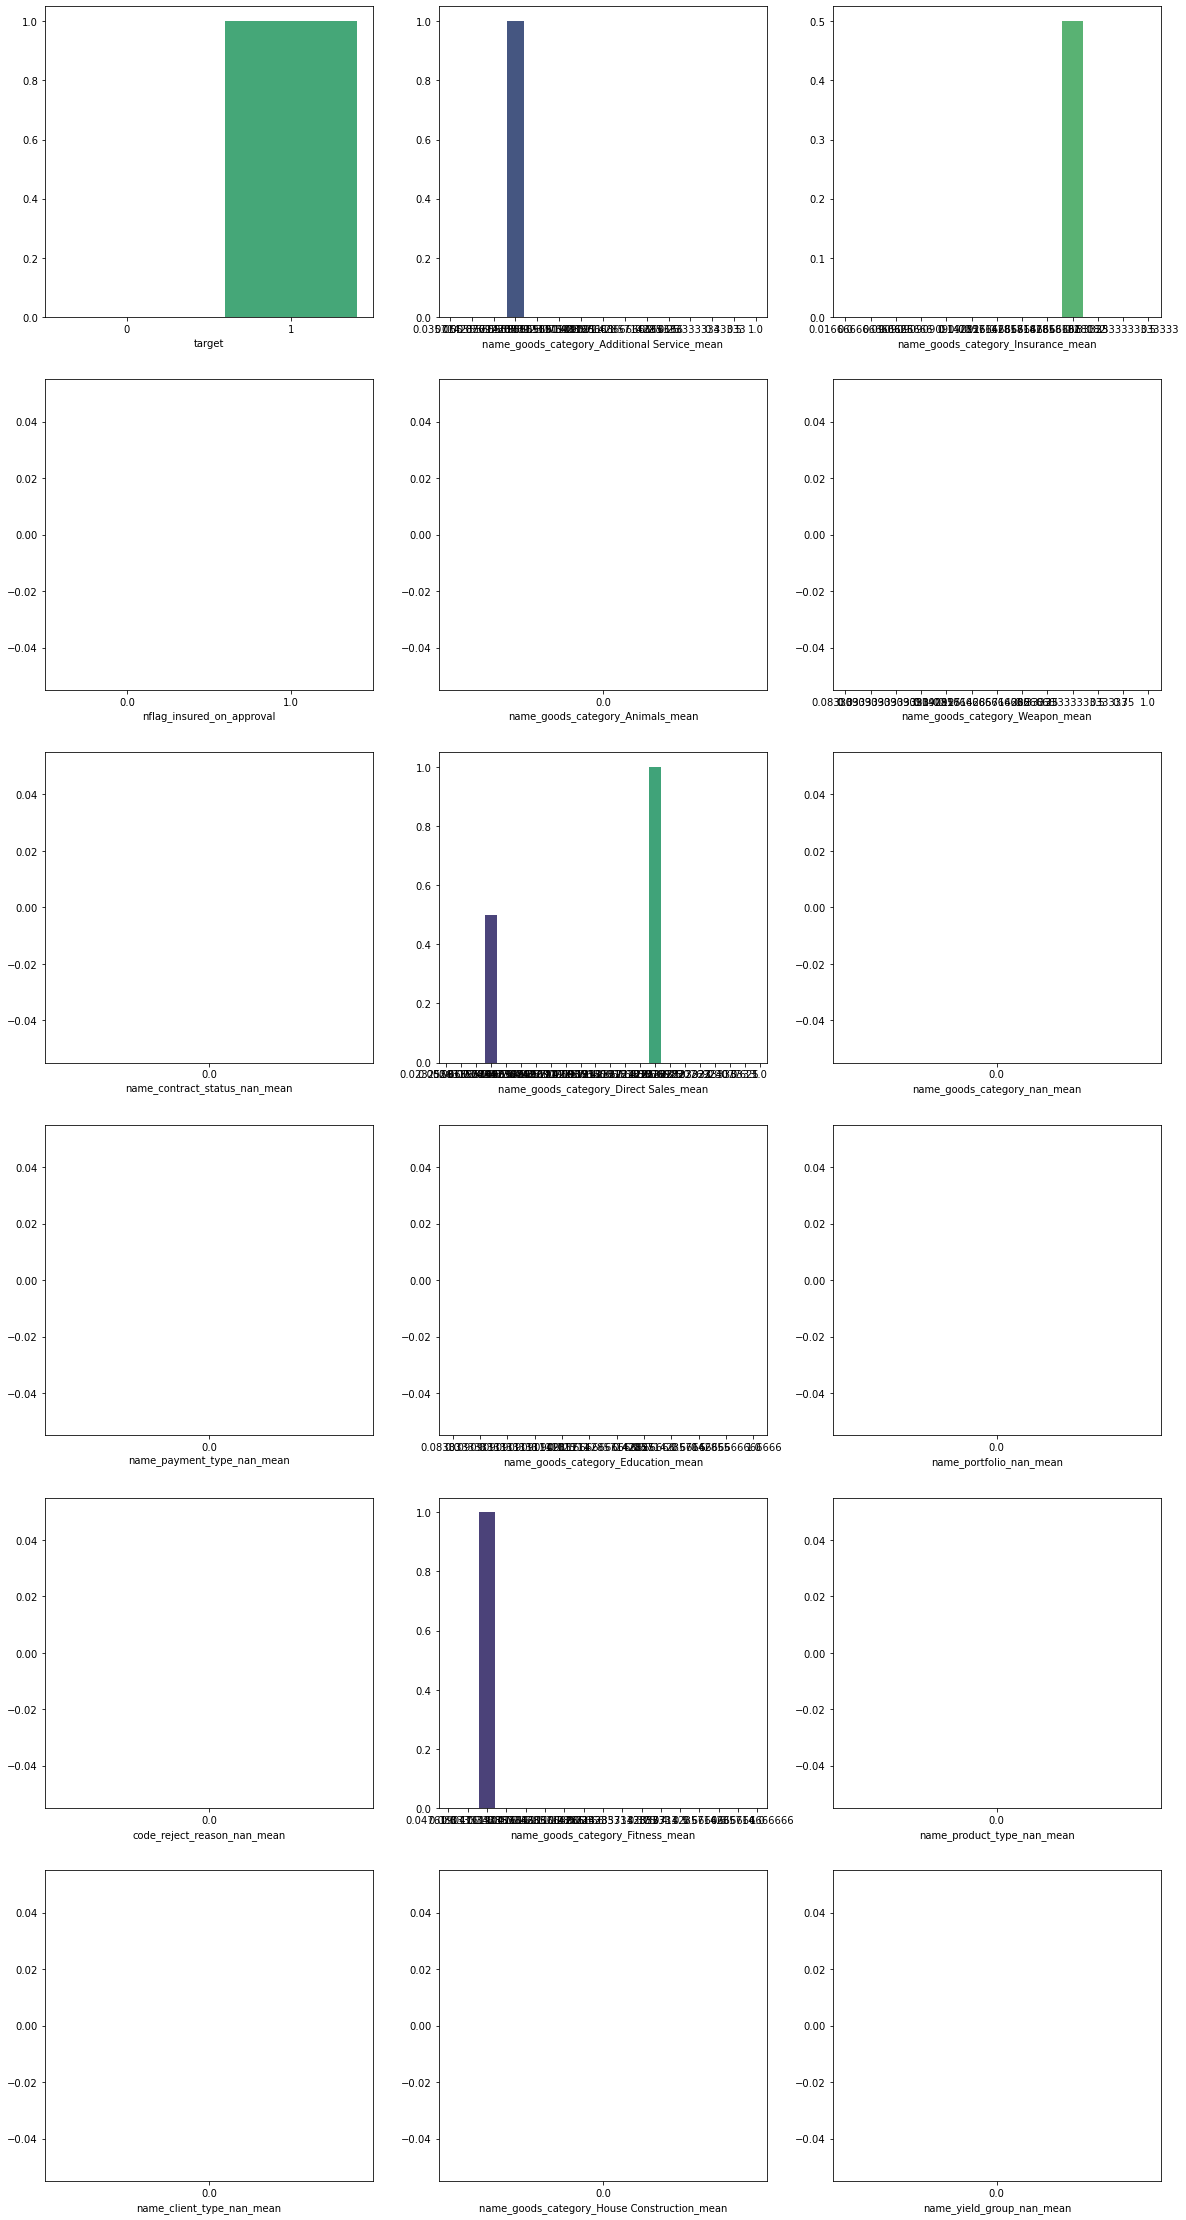

In [24]:
fig, axes = plt.subplots(6, 3, figsize=(20, 40))

for num, feature in enumerate(discrete_feature):
    data = train.copy()
    statistics = data.groupby([feature])[target_name].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%6, num//6]
    )

Большая семья явно корелирует с таргетом

In [17]:
### continuous

In [25]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 95


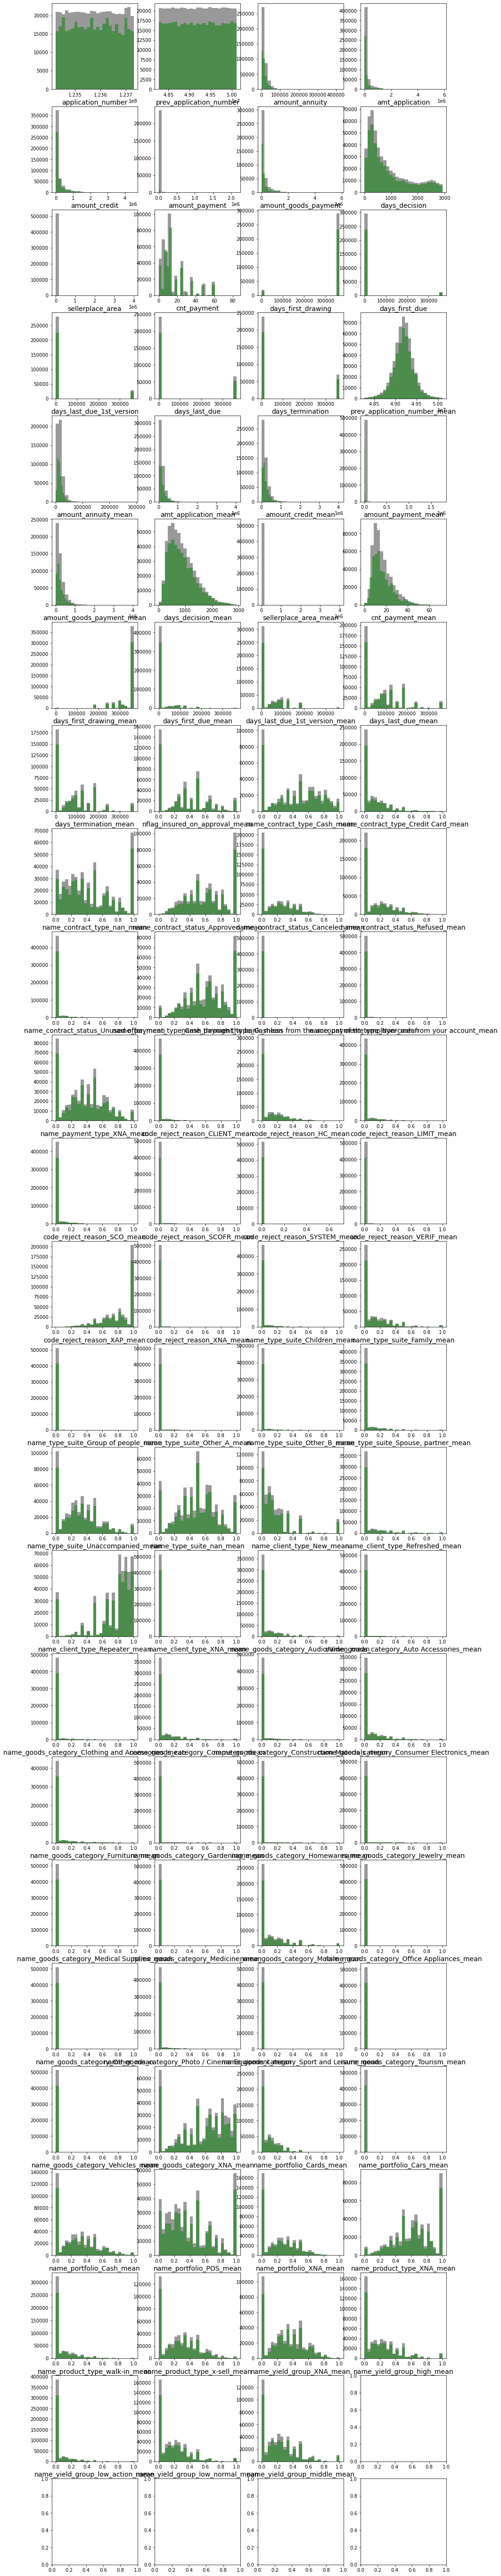

In [30]:
fig, axes = plt.subplots(24, 4, figsize=(15, 100))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    data_target = train.loc[train[target_name] == 1, feature]
    # масштабирую распределение срабатывание таргета, чтобы было видно форму
    data_target = pd.concat([data_target for _ in range(10)], axis=0)
    axes[num//4, num%4].hist(data, bins=25, color="grey", alpha=0.8)
    axes[num//4, num%4].hist(data_target, bins=25, color="green", alpha=0.5)
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)

Видим, что признаки ['amount_credit_mean', 'amount_annuity_mean', 'amount_credit', 'days_last_due_1st_version', 'days_last_due', 'days_termination', 'amount_credit'] имеют существенные отличия в распределении обычных данных и данных с таргетом = 1. Они будут полезны

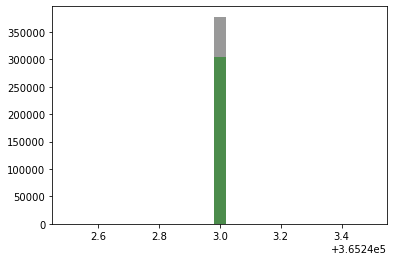

In [103]:
feature = 'days_first_drawing_mean'
data = train.copy().loc[train[feature] > 3.5e5][[feature, target_name]]
data_target = data.loc[data[target_name] == 1, feature]
# масштабирую распределение срабатывание таргета, чтобы было видно форму
data_target = pd.concat([data_target for _ in range(10)], axis=0)
plt.hist(data[feature], bins=25, color="grey", alpha=0.8)
plt.hist(data_target, bins=25, color="green", alpha=0.5)
plt.show()

In [32]:
check_missings(train)

Total NA-values = 3042465


,application_number,target,name_contract_type_x,prev_application_number,name_contract_type_y,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,...,name_product_type_XNA_mean,name_product_type_walk-in_mean,name_product_type_x-sell_mean,name_product_type_nan_mean,name_yield_group_XNA_mean,name_yield_group_high_mean,name_yield_group_low_action_mean,name_yield_group_low_normal_mean,name_yield_group_middle_mean,name_yield_group_nan_mean
Total,0,0,0,5437,230824,120338,5437,5437,282171,124232,...,5437,5437,5437,5437,5437,5437,5437,5437,5437,5437
Percent,0,0,0,1.04247,44.2571,23.0731,1.04247,1.04247,54.1022,23.8197,...,1.04247,1.04247,1.04247,1.04247,1.04247,1.04247,1.04247,1.04247,1.04247,1.04247
Types,int64,int64,object,float64,object,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [33]:
check_missings(test)

Total NA-values = 3731840


,application_number,name_contract_type_x,prev_application_number,name_contract_type_y,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,name_contract_status,...,name_product_type,sellerplace_area,cnt_payment,name_yield_group,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
Total,0,0,8057,346391,180532,8057,8057,423426,186931,8057,...,8057,8057,180529,8057,320140,320140,320140,320140,320140,320140
Percent,0,0,1.02971,44.2698,23.0725,1.02971,1.02971,54.1151,23.8904,1.02971,...,1.02971,1.02971,23.0722,1.02971,40.9149,40.9149,40.9149,40.9149,40.9149,40.9149
Types,int64,object,float64,object,float64,float64,float64,float64,float64,object,...,object,float64,float64,object,float64,float64,float64,float64,float64,float64


In [34]:
train_na_features = get_isna_features(train)
train_na_features.head()

,application_number,target,name_contract_type_x,prev_application_number,name_contract_type_y,amount_annuity,amt_application,amount_credit,amount_payment,amount_goods_payment,...,isna_name_product_type_XNA_mean,isna_name_product_type_walk-in_mean,isna_name_product_type_x-sell_mean,isna_name_product_type_nan_mean,isna_name_yield_group_XNA_mean,isna_name_yield_group_high_mean,isna_name_yield_group_low_action_mean,isna_name_yield_group_low_normal_mean,isna_name_yield_group_middle_mean,isna_name_yield_group_nan_mean
0,123687442,0,Cash,49915814.0,NaN,6510.015,71668.80,64500.3,7168.50,71668.80,...,0,0,0,0,0,0,0,0,0,0
1,123687442,0,Cash,49713743.0,NaN,9262.215,72634.14,70758.0,7267.14,72634.14,...,0,0,0,0,0,0,0,0,0,0
2,123687442,0,Cash,49704707.0,NaN,7339.185,62058.60,67518.0,3.60,62058.60,...,0,0,0,0,0,0,0,0,0,0
3,123597908,1,Cash,48716994.0,Cash,38667.600,495000.00,672948.0,NaN,495000.00,...,0,0,0,0,0,0,0,0,0,0
4,123597908,1,Cash,49672074.0,NaN,11349.900,75510.00,82156.5,0.00,75510.00,...,0,0,0,0,0,0,0,0,0,0


In [35]:
isna_features = [feature for feature in train_na_features if feature.startswith('isna_')]

In [37]:
isna_influence = dict()
for feature in isna_features:
    if feature in ['isna_application_number','isna_target','isna_name_contract_type']:
        continue
    data_target = train_na_features.loc[train_na_features[target_name] == 1]
    a = train_na_features.loc[train_na_features[feature] == 0, feature].count()
    a = a / train_na_features.loc[train_na_features[feature] == 1, feature].count()
    b = data_target.loc[data_target[feature] == 0, feature].count()
    b = b / data_target.loc[data_target[feature] == 1, feature].count()
    isna_influence[feature] = abs(a - b)
    
isna_influence = pd.DataFrame(isna_influence.items(), 
                              columns=['feature', 'influence'])\
                .sort_values(by='influence', ascending=False)
isna_influence

<ipython-input-37-84923a5f39c1>:7: RuntimeWarning: divide by zero encountered in long_scalars
  a = a / train_na_features.loc[train_na_features[feature] == 1, feature].count()
<ipython-input-37-84923a5f39c1>:9: RuntimeWarning: divide by zero encountered in long_scalars
  b = b / data_target.loc[data_target[feature] == 1, feature].count()
<ipython-input-37-84923a5f39c1>:10: RuntimeWarning: invalid value encountered in double_scalars
  isna_influence[feature] = abs(a - b)


,feature,influence
35,isna_days_first_drawing_mean,1.431685
36,isna_days_first_due_mean,1.431685
37,isna_days_last_due_1st_version_mean,1.431685
38,isna_days_last_due_mean,1.431685
39,isna_days_termination_mean,1.431685
...,...,...
23,isna_days_last_due,0.006352
22,isna_days_last_due_1st_version,0.006352
21,isna_days_first_due,0.006352
12,isna_name_type_suite,0.005844


отберем самые важные:

In [38]:
isna_influence.loc[isna_influence['influence'] > 0.2, 'feature'].tolist()

['isna_days_first_drawing_mean',
 'isna_days_first_due_mean',
 'isna_days_last_due_1st_version_mean',
 'isna_days_last_due_mean',
 'isna_days_termination_mean',
 'isna_nflag_insured_on_approval_mean',
 'isna_amount_payment_mean',
 'isna_cnt_payment_mean',
 'isna_name_goods_category_Homewares_mean',
 'isna_name_goods_category_Gardening_mean',
 'isna_name_goods_category_Furniture_mean',
 'isna_name_goods_category_Fitness_mean',
 'isna_name_goods_category_Education_mean',
 'isna_name_goods_category_Direct Sales_mean',
 'isna_name_goods_category_Consumer Electronics_mean',
 'isna_name_goods_category_Construction Materials_mean',
 'isna_prev_application_number',
 'isna_name_goods_category_Clothing and Accessories_mean',
 'isna_name_goods_category_Auto Accessories_mean',
 'isna_name_goods_category_Audio/Video_mean',
 'isna_name_goods_category_Animals_mean',
 'isna_name_goods_category_Additional Service_mean',
 'isna_name_client_type_nan_mean',
 'isna_name_client_type_XNA_mean',
 'isna_name_c